# T012 · Data acquisition from KLIFS

Authors:

- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

KLIFS is a database for kinase-ligand interaction fingerprints and structures. We show in this talktorial how to use the programmatic access of this database (KLIFS Swagger API) and the `opencadd` package to get kinase-ligand structures for a query kinase.

### Contents in *Theory*

- Kinases
- KLIFS database
- KLIFS Swagger API
- OpenCADD

### Contents in *Practical*

- Generate a KLIFS Python client
- Define kinase and ligand of interest: EGFR and Gefitinib
- Explore the KLIFS Swagger API
- Get structures for a query kinase
- Select an example structure
- Show the structure with `nglview`
- Show the ligand with `rdkit`

### References

* Kinase-centric computational drug development ([_Annu. Rep. Med. Chem._ (2017), __50__, 197-236](https://www.sciencedirect.com/science/article/pii/S0065774317300040?via%3Dihub))
* KLIFS, a kinase-inhibitor interactions database.
   * Main database/website reference ([_Nucleic Acids Res._ (2020)](https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkaa895/5934416))
   * Introduction of the KLIFS website & database ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
   * Initial KLIFS dataset, binding mode classification, residue numbering ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
* NGLView, the interactive molecule visualizer ([_Bioinformatics_ (2018), __34__, 1241–124](https://doi.org/10.1093/bioinformatics/btx789))

## Theory

### Kinases

Protein kinases are one the most important and well-studied drug targets, since they are critical to most aspects of cell life and their dysregulation causes many diseases such as cancer, inflammation, and autoimmune disorders.
Since this protein class is so well-studied, the amount of available data is growing more and more, allowing and requiring infrastructures that organize, analyze, and provide this data to facilitate kinase-centric drug development ([_Annu. Rep. Med. Chem._ (2017), __50__, 197-236](https://www.sciencedirect.com/science/article/pii/S0065774317300040?via%3Dihub)). One of these rich resources is the KLIFS database, which will be used in this talktorial.

TODO: There are 518 kinases encoded in the human genome, which were clustered based on their sequence into eight main kinase groups (AGC, CAMK, CK1, CMGC, STE, TK, TKL and Other). Each kinase group is further categorized into different kinase families. 

### KLIFS database

The __K__inase-__L__igand __I__nteraction __F__ingerprints and __S__tructures database (KLIFS) is a database that provides information about the protein structure (collected from the PDB) of catalytic kinase domains and the interaction with their ligands. 

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.net/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.net/swagger/
* Literature:
   * Main database/website reference ([_Nucleic Acids Res._ (2020)](https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkaa895/5934416))
   * Introduction of the KLIFS website & database ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
   * Initial KLIFS dataset, binding mode classification, residue numbering ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

### KLIFS Swagger API

The KLIFS database offers standardized URL schemes (__REST API__) to programmatically access - from your computer - resources that live on the KLIFS server. You could literally paste such an URL into your browser (sending a __request__) and you would get back a result (receiving a __response__).

Now, it would be possible to generate these URL schemes with your own little script or library (__client__), but it would _really_ be nicer if you would not need to deal with the technical details of how to set up such an URL. 
Luckily, there is a solution - some websites provide you with a document that defines these REST API schema for you (__Swagger definitions__). 
Luckily again, KLIFS is one of them! 

- Take a look at how such a document looks like in case of KLIFS (it's a json file): https://klifs.net/swagger/swagger.json 
- You can also explore the definitions interactively using Swaggers user interface (Swagger UI): http://klifs.net/swagger/

We are getting closer. We know now that we can get KLIFS results using URLs and we know thanks to the KLIFS Swagger definitions how these URLs need to look like. 
What we are still missing is a nice Python program (client) that offers a simple API to send these requests and receive the responses - under the hood - for us.

We are lucky once more. Libraries like `bravado` can be used to generate dynamically such a Python client based on Swagger definitions - for our webservice at hand here, `bravado` can be used to generate a KLIFS client based on the KLIFS Swagger definitions. This KLIFS client will offer many different methods to interact with the KLIFS webservice (as defined by the Swagger definitions). In the "Practical" section of this talktorial, we will revisit these steps!

### `opencadd`

`opencadd` is a Python library for structural cheminformatics developed by the Volkamber lab at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics, e.g. a module for structural superimposition (`opencadd.structure.superpsition`) or KLIFS queries (`opencadd.databases.klifs`).

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

We will use the KLIFS-dedicated module in this talktorial. It offers a standardized API to work with KLIFS data locally (KLIFS download) or remotely (KLIFS Swagger API). Most query results are returned in the form of standardized `pandas` DataFrames for quick and easy data manipulation.

## Practical

We can obtain curated protein structures from this database for a query kinase to extract ligand information for that kinase. 
This set of ligands could be used to retrieve similar ligands from other databases, like PubChem (__Talktorial T013__) or ChEMBL (__Talktorial T001+T004__).

TODO: We will first show how to access the KLIFS database (a) using the KLIFS Swagger API and (b) using `opencadd`'s unofficial KLIFS client.

### Generate a KLIFS Python client

First, we will generate a KLIFS Python client using the provided KLIFS Swagger definitions.

In [1]:
import random
from tempfile import NamedTemporaryFile
import time

from bravado.client import SwaggerClient
import pandas as pd
import nglview as nv
from rdkit import Chem
from rdkit.Chem.Draw import (
    IPythonConsole,
    MolsToGridImage,
)  # Needed to show molecules
import opencadd

pd.set_option('display.max_columns', 50)

In [2]:
KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

As with any Python library, you can access the KLIFS client's entry points when hitting the Tab key after 

```python
KLIFS_CLIENT.
```

Available entry points are: 

- `KLIFS_CLIENT.Information`: Access to kinases (name, group, family, ...).
- `KLIFS_CLIENT.Interactions`: Access to kinase-ligand interaction fingerprints.
- `KLIFS_CLIENT.Ligands`: Access to kinase-bound ligands (name, SMILES, ...) and their measured bioactivity against kinases (ChEMBL data).
- `KLIFS_CLIENT.Structures`: Access to kinase structures with and without ligands (including their KLIFS-processed PDB data).

### Define kinase and ligand of interest: EGFR and Gefitinib

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. 

Gefitinib is an already approved EGFR inhibitor [PubChem](https://pubchem.ncbi.nlm.nih.gov/compound/Gefitinib) with the ligand Expo ID "IRE".

In [3]:
species = "Human"
kinase_group = "TK"
kinase_family = "EGFR"
kinase_name = "EGFR"
ligand_expo_id = "IRE"

### Explore the KLIFS Swagger API

Let's send a few requests to KLIFS to explore available data for our kinase and ligand of interest.

1. Let's check out the available __kinase groups__.

In [4]:
kinase_groups = KLIFS_CLIENT.Information.get_kinase_groups().response().result
print("All kinase groups:\n", *kinase_groups)

All kinase groups:
 AGC CAMK CK1 CMGC Other STE TK TKL


2. Now let's look at our all available __kinase families__ for the kinase group of interest (`kinase_group`).

In [5]:
kinase_families = KLIFS_CLIENT.Information.get_kinase_families(kinase_group=kinase_group).response().result
print(f"Kinase families in {kinase_group}:\n", *kinase_families)

Kinase families in TK:
 ALK Abl Ack Alk Axl CCK4 Csk DDR EGFR Eph FAK FGFR Fer InsR JakA JakB Lmr Met Musk PDGFR Ret Ror Ryk Sev Src Syk TK-Unique Tec Tie Trk VEGFR


3. The following __kinases__ belong to the kinase family of interest (`kinase_family`):

In [6]:
kinases = KLIFS_CLIENT.Information.get_kinase_names(kinase_family=kinase_family, species=species).response().result
kinases

[IDlist(full_name='epidermal growth factor receptor', kinase_ID=406, name='EGFR', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 2', kinase_ID=407, name='ERBB2', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 3', kinase_ID=408, name='ERBB3', species='Human'),
 IDlist(full_name='erb-b2 receptor tyrosine kinase 4', kinase_ID=409, name='ERBB4', species='Human')]

4. For this notebook we are interested in the kinase `kinase_name`. 
Let extract the KLIFS ID for this kinase, which we will use to query for structures in KLIFS.

In [7]:
kinase_klifs_id = [kinase["kinase_ID"] for kinase in kinases if kinase["name"]==kinase_name][0]
print(f"Kinase KLIFS ID for {kinase_name}: {kinase_klifs_id}")

Kinase KLIFS ID for EGFR: 406


5. Get all available structures in KLIFS for this kinase.

In [8]:
structures = KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=[kinase_klifs_id]).response().result
print(f"Number of structures for the kinase {kinase_name}: {len(structures)}")

Number of structures for the kinase EGFR: 425


Look at the first structure as an example. We get information about the kinases that the structure represents, about the bound ligand (if any) and about the structure quality and conformation.

In [9]:
structures[0]

structureDetails(DFG='in', Grich_angle=48.1597, Grich_distance=14.8202, Grich_rotation=43.046, aC_helix='out', allosteric_ligand=0, alt='A', back=True, bp_III=False, bp_II_A_in=True, bp_II_B=False, bp_II_B_in=False, bp_II_in=True, bp_II_out=False, bp_IV=False, bp_I_A=True, bp_I_B=True, bp_V=False, chain='A', fp_I=False, fp_II=False, front=True, gate=True, kinase='EGFR', kinase_ID=406, ligand='W19', missing_atoms=0, missing_residues=0, pdb='3w33', pocket='KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQLMPFGCLLDYVREYLEDRRLVHRDLAARNVLVITDFGLA', quality_score=8.0, resolution=1.7, rmsd1=0.814, rmsd2=2.153, species='Human', structure_ID=782)

6. Get the structural data for this first structure in the form of a string that contains the file content for the kinase-ligand complex. Show only the first 10 file rows.

In [10]:
complex_coordinates = KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID).response().result
complex_coordinates.split('\n')[:10]

['HEADER    3w33.A                                                      ',
 'REMARK  99                                                                      ',
 'REMARK  99 MOE v2012.10 (Chemical Computing Group Inc.) Fri Mar  3 16:17:14 2017',
 'HELIX    1   1 GLU A  709  GLU A  711  5               Generated by MOE    3',
 'HELIX    2   2 ASN A  756  SER A  768  1               Generated by MOE   13',
 'HELIX    3   3 LEU A  798  HIS A  805  1               Generated by MOE    8',
 'HELIX    4   4 LYS A  806  ASN A  808  5               Generated by MOE    3',
 'HELIX    5   5 SER A  811  ASP A  830  1               Generated by MOE   20',
 'HELIX    6   6 ALA A  840  ASN A  842  5               Generated by MOE    3',
 'HELIX    7   7 LEU A  858  LEU A  861  1               Generated by MOE    4']

### Get structures for a query kinase

After introducing the KLIFS Swagger API above, we will use now the `opencadd.databases.klifs` module, which is a wrapper for this KLIFS client. 
As mentioned in the _Theory_ section of this talktorial, this module returns all responses as `pandas` DataFrames for easy and quick manipulation.
This comes in handy when we want to quickly inspect and filter the structure results.

In [11]:
from opencadd.databases.klifs import setup_remote
session = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [12]:
structures = session.structures.by_kinase_klifs_id(kinase_klifs_id)
print(f"Number of structures for the kinase {kinase_name}: {len(structures)}")

Number of structures for the kinase EGFR: 425


### Select an example structure

Keep only structures bound by a ligand of interest (`ligand_expo_id`), sort them by highest resolution and keep show the top 10 structures.

In [13]:
structures[(structures["ligand.expo_id"] == ligand_expo_id)].sort_values(by="structure.resolution").head(10)

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
42,823,4i22,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,out,1.71,8.0,0,0,0.810,2.159,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,14.6390,47.5394,47.9735,None
47,837,4wkq,B,A,Human,406,EGFR,None,None,KVLGSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,1.85,6.7,5,13,0.776,1.995,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
93,889,4wkq,A,A,Human,406,EGFR,None,None,KVLGSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,1.85,6.7,5,13,0.776,1.995,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
23,819,3ug2,B,A,Human,406,EGFR,None,None,KVLSSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,in,2.50,7.6,4,8,0.778,2.014,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
98,898,3ug2,A,A,Human,406,EGFR,None,None,KVLSSG___TVYKVAIKE_EILDEAYVMASVDPHVCRLLGIQLIMQ...,IRE,-,None,None,in,in,2.50,7.6,4,8,0.778,2.014,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
18,789,2itz,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,2.72,9.4,0,6,0.776,2.097,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.0567,58.1317,30.0730,None
2,783,2ito,-,A,Human,406,EGFR,None,None,KVLSSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,3.25,8.0,0,0,0.778,2.096,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,19.7766,63.3167,23.7491,None
20,790,2ity,-,A,Human,406,EGFR,None,None,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,IRE,-,None,None,in,in,3.42,8.0,0,0,0.778,2.103,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,19.5474,62.9767,21.9343,None


In [14]:
structure_klifs_id = structures[(structures["ligand.expo_id"] == ligand_expo_id)].sort_values(by="structure.resolution").iloc[0]["structure.klifs_id"]
print(f"Structure KLIFS ID for best resolved {ligand_expo_id}-bound {kinase_name}: {structure_klifs_id}")

Structure KLIFS ID for best resolved IRE-bound EGFR: 823


### Show the structure with `nglview`

Let's preview the protein-ligand complex and protein with `nglview`.

In [15]:
def show_molecule(structure_text, extension="mol2"):
    """
    Show molecule with the nglview.
    
    Parameters
    ----------
    structure_text : str
        Structural data in the form of a string.
    extension : str
        Format of the structural data (default: mol2).
    """
    
    v = nv.NGLWidget()
    v.add_component(structure_text, ext=extension)
    return v

Let's check what kind of structural data we can get from the KLIFS database (docstring inspection).

In [16]:
session.coordinates.to_text?

Signature:
session.coordinates.to_text(
    structure_klifs_id,
    entity='complex',
    extension='mol2',
)
Docstring:
Get structural data content from KLIFS database as string (text).

Parameters
----------
structure_klifs_id : int
    Structure KLIFS ID.
    In the local module, this parameter is called "structure_klifs_id_or_filepath".
structure_klifs_id_or_filepath : int / str or pathlib.Path
    Structure KLIFS ID or path to file.
    In the remote module, this parameter is called "structure_klifs_id".
entity : str
    Structural entity: complex (default), ligand, pocket, or protein.
    In the local module, when a filepath is passed to "structure_klifs_id_or_filepath", this
    parameter will be ignored and inferred from the filepath instead.
extension : str
    Input file format (fetched from KLIFS): mol2 (default) or pdb.
    In the local module, when a filepath is passed to "structure_klifs_id_or_filepath", this
    parameter will be ignored and inferred from the filepath in

In [17]:
structure_text = session.coordinates.to_text(structure_klifs_id, "complex", "mol2")
v = show_molecule(structure_text)
v

NGLWidget()

In [18]:
v.render_image();

In [19]:
v._display_image()

In [20]:
structure_text = session.coordinates.to_text(structure_klifs_id, "protein", "mol2")
v = show_molecule(structure_text)
v

NGLWidget()

In [21]:
v.render_image();

In [22]:
v._display_image()

### Show the ligand with `rdkit`

The `opencadd.databases.klifs` module can also be used to quickly show the bound ligand using `rdkit`.

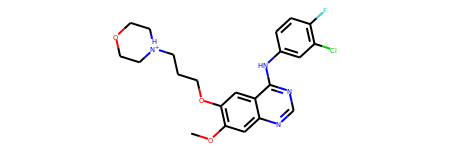

In [23]:
session.coordinates.to_rdkit(structure_klifs_id, "ligand")

We can also get this ligand's SMILES via the ligand Expo ID (KLIFS query).

In [24]:
session.ligands.by_ligand_expo_id(ligand_expo_id)

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,222,IRE,Gefitinib,Clc1c(F)ccc(Nc2ncnc3c2cc(OCCCN4CCOCC4)c(OC)c3)c1,XGALLCVXEZPNRQ-UHFFFAOYSA-N


### Explore kinases in KLIFS

To quickly explore the resources on different kinases in KLIFS, we define a function that allows us to return (a) all structure-bound ligands in KLIFS plus (b) one random structure for a random kinase or given kinase(s).

In [25]:
def random_kinase_structure(*kinase_names):
    """
    Get one example structure (complex and protein structural data) for one or more kinases plus the SMILES of all bound ligands.
    
    Parameters
    ----------
    *kinase_names : str
        Kinase names.
        
    Returns
    -------
    (molcomplex, protein, ligands) : (str, str, list of str)
        Complex structural data, protein structural data, list of ligand SMILES.
    """
    # Get all structures or all structures for a given kinase
    if kinase_names:
        kinase_names = list(kinase_names)
        try:
            structures = session.structures.by_kinase_name(list(kinase_names))
        except ValueError:
            raise ValueError(f"The input kinase(s) {kinase_names} yielded no results.")
    else:
        structures = session.structures.all_structures()
    kinase_klifs_ids = [int(i) for i in structures["kinase.klifs_id"].unique()]
    # Choose random structure
    structure = structures.sample().squeeze()
    structure_klifs_id = structure["structure.klifs_id"]
    print(f"Selected kinases: {structure['kinase.klifs_name']}")
    # Get complex structural data
    molcomplex = (
        KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(
            structure_ID=structure_klifs_id
        )
        .response()
        .result
    )
    # Get protein structural data
    protein = (
        KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structure_klifs_id)
        .response()
        .result
    )
    # Get all ligands bound to all structures for input kinases
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_klifs_ids).response().result
    print(
        f"Chosen KLIFS entry: PDB ID {structure['structure.pdb_id']} "
        f"with chain {structure['structure.chain'] if structure['structure.chain'] else '-'} and "
        f"alternate model {structure['structure.alternate_model'] if structure['structure.alternate_model'] else '-'} "
        f"({structure['species.klifs'].lower()})."
    )
    print(f"Number of structure-bound ligands: {len(ligands)}")
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

In [26]:
molcomplex, protein, ligands = random_kinase_structure("p38a", "EGFR")

Selected kinases: EGFR
Chosen KLIFS entry: PDB ID 5em7 with chain A and alternate model A (human).
Number of structure-bound ligands: 395


/home/dominique/.local/miniforge3/envs/teachopencadd-review/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(


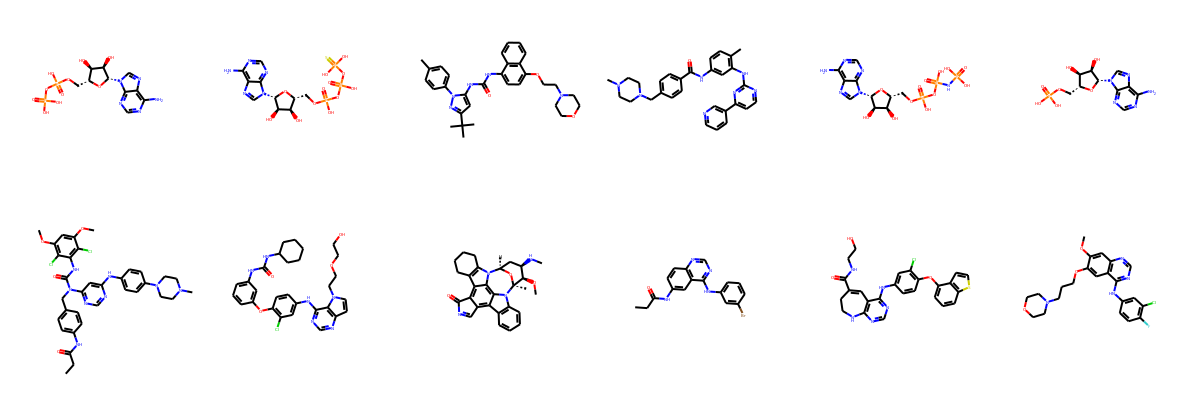

In [27]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(ligand) for ligand in ligands], maxMols=12, molsPerRow=6
)

In [28]:
v = show_molecule(molcomplex, "pdb")
v

NGLWidget()

In [29]:
v.render_image();

In [30]:
v._display_image()

## Discussion

**TODO**

## Quiz

- How many kinases does KLIFS provide for the "EGFR" family?
- **TODO**
- **TODO**